In [1]:
import sys 
sys.path.append('../')

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
from scipy.fftpack import fftn, ifftn, fftfreq
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [3]:
%load_ext autoreload
%autoreload 2
from database import Magneticum

In [4]:
dataframe_clu = Magneticum('022','b','cluster').dataframe


In [5]:
dataframe_gal = Magneticum('022','b','galaxies').dataframe

In [6]:
df1 = pd.DataFrame.from_dict(
                            {'x':dataframe_clu['x[kpc/h]']/0.7,
                            'y':dataframe_clu['y[kpc/h]']/0.7,
                            'z':dataframe_clu['z[kpc/h]']/0.7,
                            'vx':dataframe_clu['vx[km/s]'],
                            'vy':dataframe_clu['vy[km/s]'],
                            'vz':dataframe_clu['vz[km/s]'],
                            }   
                            )

In [7]:
df2 = pd.DataFrame.from_dict(
                            {'x':dataframe_gal['x[kpc/h]']/0.7,
                            'y':dataframe_gal['y[kpc/h]']/0.7,
                            'z':dataframe_gal['z[kpc/h]']/0.7,
                            }
                            )

In [16]:
from scipy.spatial import KDTree

def count_galaxies_around_halos_fast(df1, df2, r=10):
    r = (r*u.Mpc).to(u.kpc).value
    galaxies_tree = KDTree(df2[['x', 'y', 'z']])

    # Initialize an empty list to hold the counts of galaxies around each halo
    galaxy_counts = []

    # Loop through each halo in df1
    for ih in tqdm(df1.iterrows(),unit='halo'):
        halo = ih[1]
        # Count the number of galaxies within r of this halo using the KDTree
        count = galaxies_tree.query_ball_point([halo['x'], halo['y'], halo['z']], r=r)

        # Add the count to the list
        galaxy_counts.append(len(count))

    # Add the galaxy counts as a new column to df1
    df1['galaxy_count'] = galaxy_counts

    return df1

In [40]:
galaxies_tree = KDTree(df2[['x', 'y', 'z']],copy_data=True)

In [91]:
count = []
for i in range(len(df1)):
    count.append(len(galaxies_tree.query_ball_point(np.array(df1[['x','y','z']].iloc[i]), r=(10*u.Mpc).to(u.kpc).value)))

In [92]:
df1['dg']=(count - np.mean(count))/np.mean(count)

In [93]:
dg = df1['dg'].values

In [116]:
dg_k = np.fft.fftn(dg)

In [117]:
N = dg.shape[0] 
k = np.fft.fftfreq(N) * 2.0 * np.pi

In [121]:
k_half = k[:N//2]

    # Create 1D arrays for kx, ky, and kz
kx = np.reshape(k_half, (N//2, 1, 1))
ky = np.reshape(k_half, (1, N//2, 1))
kz = np.reshape(k_half, (1, 1, N//2))

In [123]:
def calculate_velocity_field(density_field, scale_factor, hubble_parameter, growth_rate):
    # Calculate the mean density
    mean_density = np.mean(density_field)

    # Calculate the density contrast field
    density_contrast_field = (density_field - mean_density) / mean_density

    # Fourier transform the density contrast field
    density_contrast_fourier = np.fft.fftn(density_contrast_field)

    # Generate a grid of wavevectors
    N = density_field.shape[0]  # assuming the density field is a cubic grid with equal size in all dimensions
    k = np.fft.fftfreq(N) * 2.0 * np.pi

    # Create a grid of k values corresponding to each point in the Fourier space
    kx, ky, kz = np.meshgrid(k, k, k, indexing='ij')

    # Calculate the magnitude of k at each point
    k_magnitude = np.sqrt(kx**2 + ky**2 + kz**2)
    
    # Avoid division by zero
    k_magnitude[k_magnitude == 0] = 1

    # Calculate the velocity field in Fourier space
    velocity_fourier = -1j * scale_factor * hubble_parameter * growth_rate * density_contrast_fourier / k_magnitude

    # Inverse Fourier transform the velocity field to get back to position space
    velocity_field = np.fft.ifftn(velocity_fourier)

    # The velocity field is complex due to numerical errors, but the imaginary part should be very small
    # We take the real part to get a real-valued velocity field
    velocity_field = np.real(velocity_field)

    return velocity_field

In [125]:
v = calculate_velocity_field(dg, 1)

/tmp/ipykernel_3358335/3443685652.py:6: RuntimeWarning: divide by zero encountered in true_divide
  density_contrast_field = (density_field - mean_density) / mean_density
/tmp/ipykernel_3358335/3443685652.py:21: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  velocity_field = np.zeros_like(density_field, dtype=np.complex)


MemoryError: Unable to allocate 13.2 GiB for an array with shape (1, 42028, 42028) and data type float64

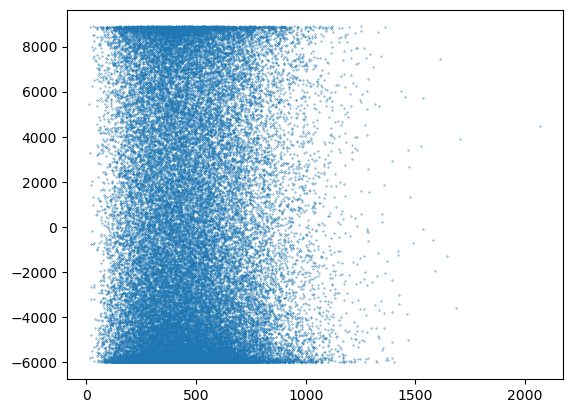

In [114]:
plt.scatter(np.sqrt(df1['vz']**2+df1['vx']**2+df1['vy']**2),s.real,s=0.1)


In [115]:
np.corrcoef(np.abs(df1['vx']),np.abs(s))

array([[ 1.00000000e+00, -2.86973423e-04],
       [-2.86973423e-04,  1.00000000e+00]])